# Universal Cokriging插值法

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
a = 1.7
c_o = 10
i_res = 4
gi_res = 2
nugget_scalar = 2e-5
nugget_grad = 1e-2
epsilon =1e-5

res = 20
ran = 1000

def cov_cubic_f(r, a=a):
    if r > a:
        ans_d0 = 0
    else:
        ans_d0 = 1 - 7 * (r / a) ** 2 + 35 * r ** 3 / (4 * a ** 3) - 7 * r ** 5 / (2 * a ** 5) + 3 * r ** 7 / (4 * a ** 7)
    return ans_d0

cov_cubic_f = np.vectorize(cov_cubic_f)

# C'/r
def cov_cubic_d1_f(r, a=a):
    if r>a:
        ans_d1 = 0
    else:
        ans_d1 = (-14 / a ** 2) + 105 * r / (4 * a ** 3) - 35 * r ** 3 / (2 * a ** 5) + 21 * r ** 5 / (4 * a ** 7)
    return ans_d1

cov_cubic_d1_f = np.vectorize(cov_cubic_d1_f)
                    
def cov_cubic_d2_f(r, a=a):
    if r>a:
        ans_d2 = 0
    else:
        ans_d2 = 7 * (9 * r ** 5 - 20 * a ** 2 * r ** 3 + 15 * a ** 4 * r - 4 * a ** 5) / (2 * a ** 7)
    return ans_d2

cov_cubic_d2_f = np.vectorize(cov_cubic_d2_f)

def K_Z(h):
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    return cov_cubic_f(r)

# cross-cov space-grad
def K_ZGx(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    hx = h[0]
    return hx * cov_cubic_d1_f(r)

def K_ZGy(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    hy = h[1]    
    return hy * cov_cubic_d1_f(r)

def K_ZGz(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    hz = h[2]    
    return hz * cov_cubic_d1_f(r)

# cov grad
def K_Gx(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    rr = epsilon if r == 0 else r
    hx = h[0]
    return (hx**2/(r**2+ epsilon)) * (-cov_cubic_d2_f(rr) + cov_cubic_d1_f(rr)) - cov_cubic_d1_f(rr)


def K_Gy(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    rr = epsilon if r == 0 else r
    hy = h[1]
    return (hy**2/(r**2+ epsilon)) * (-cov_cubic_d2_f(rr) + cov_cubic_d1_f(rr)) - cov_cubic_d1_f(rr)
    
def K_Gz(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    rr = epsilon if r == 0 else r
    hz = h[2]
    return (hz**2/(r**2+ epsilon)) * (-cov_cubic_d2_f(rr) + cov_cubic_d1_f(rr)) - cov_cubic_d1_f(rr)

# cross-cov grad
def K_GxGy(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    hx = (h[0])
    hy = (h[1])
    if r == 0:
        return 0
    else:
        return hx * hy /(r**2 + epsilon) * (cov_cubic_d1_f(r) - cov_cubic_d2_f(r))
    
def K_GxGz(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    hx = (h[0])
    hz = (h[2])
    if r == 0:
        return 0
    else:
        return hx * hz /(r**2 + epsilon) * (cov_cubic_d1_f(r) - cov_cubic_d2_f(r))
        
def K_GyGz(h):
    """Note: requires the vector h!"""
    r = np.sqrt(h[0]**2 + h[1]**2 + h[2]**2)
    hy = (h[1])
    hz = (h[2])
    if r == 0:
        return 0
    else:
        return hy * hz /(r**2 + epsilon) * (cov_cubic_d1_f(r) - cov_cubic_d2_f(r))
    
#import numpy as np, sys
#np.set_printoptions(linewidth=10**9)
#np.set_printoptions(threshold=sys.maxsize)

In [2]:
import numpy as np
# interface points:

#i0 = [120,600,100] # interface 1:
#i1 = [800,200,200]
#i2 = [450,180,250]
#i3 = [150,460,760] ## interface 2:
#i4 = [880,120,700]
#i5 = [500,700,730]

i0 = [200,700,150]
i1 = [700,300,100]
i2 = [440,190,150]
i3 = [140,400,790]
i4 = [880,120,420]
i5 = [560,700,640]
i = np.vstack([i0, i1, i2, i3, i4, i5])
# orientation point:
o0 = [300,800,500]
o1 = [600,0,400]
o2 = [800,500,400]
o = np.vstack([o0, o1, o2])
# orientation values
gx0 = 1.
gy0 = 0.
gz0 = 1.
gx1 = -1.
gy1 = 0.
gz1 = 1.
gx2 = -1.
gy2 = 0.
gz2 = 1.
#120,600,100,0
#800,200,200,0
#450,180,250,0
#150,460,760,1
#880,120,700,1
#500,700,730,1

#200,700,150,0
#700,300,100,0
#440,190,150,0
#140,400,790,1
#880,120,420,1
#560,700,640,1

In [3]:
io = np.vstack([i,o])
SCALE = np.max([np.max(io[:,0]) - np.min(io[:,0]),np.max(io[:,1]) - np.min(io[:,1]),np.max(io[:,2]) - np.min(io[:,2])]) * 2
SCALE = SCALE.astype(np.float64, copy=False)
X0 = (np.max(io[:,0]) + np.min(io[:,0])) / 2
Y0 = (np.max(io[:,1]) + np.min(io[:,1])) / 2
Z0 = (np.max(io[:,2]) + np.min(io[:,2])) / 2
i = i.astype(np.float64, copy=False)
i[:, 0] = (i[:, 0] - X0) / SCALE
i[:, 1] = (i[:, 1] - Y0) / SCALE
i[:, 2] = (i[:, 2] - Z0) / SCALE
o = o.astype(np.float64, copy=False)
o[:, 0] = (o[:, 0] - X0) / SCALE
o[:, 1] = (o[:, 1] - Y0) / SCALE
o[:, 2] = (o[:, 2] - Z0) / SCALE

In [4]:
C_G = np.array([
    [K_Gx(o[0]-o[0]),   K_Gx(o[0]-o[1]),   K_Gx(o[0]-o[2]),   K_GxGy(o[0]-o[0]), K_GxGy(o[0]-o[1]), K_GxGy(o[0]-o[2]), K_GxGz(o[0]-o[0]), K_GxGz(o[0]-o[1]), K_GxGz(o[0]-o[2])], 
    [K_Gx(o[1]-o[0]),   K_Gx(o[1]-o[1]),   K_Gx(o[1]-o[2]),   K_GxGy(o[1]-o[0]), K_GxGy(o[1]-o[1]), K_GxGy(o[1]-o[2]), K_GxGz(o[1]-o[0]), K_GxGz(o[1]-o[1]), K_GxGz(o[1]-o[2])], 
    [K_Gx(o[2]-o[0]),   K_Gx(o[2]-o[1]),   K_Gx(o[2]-o[2]),   K_GxGy(o[2]-o[0]), K_GxGy(o[2]-o[1]), K_GxGy(o[2]-o[2]), K_GxGz(o[2]-o[0]), K_GxGz(o[2]-o[1]), K_GxGz(o[2]-o[2])], 
    
    [K_GxGy(o[0]-o[0]), K_GxGy(o[0]-o[1]), K_GxGy(o[0]-o[2]), K_Gy(o[0]-o[0]),   K_Gy(o[0]-o[1]),   K_Gy(o[0]-o[2]),   K_GyGz(o[0]-o[0]), K_GyGz(o[0]-o[1]), K_GyGz(o[0]-o[2])],   
    [K_GxGy(o[1]-o[0]), K_GxGy(o[1]-o[1]), K_GxGy(o[1]-o[2]), K_Gy(o[1]-o[0]),   K_Gy(o[1]-o[1]),   K_Gy(o[1]-o[2]),   K_GyGz(o[1]-o[0]), K_GyGz(o[1]-o[1]), K_GyGz(o[1]-o[2])],   
    [K_GxGy(o[2]-o[0]), K_GxGy(o[2]-o[1]), K_GxGy(o[2]-o[2]), K_Gy(o[2]-o[0]),   K_Gy(o[2]-o[1]),   K_Gy(o[2]-o[2]),   K_GyGz(o[2]-o[0]), K_GyGz(o[2]-o[1]), K_GyGz(o[2]-o[2])],   
    
    [K_GxGz(o[0]-o[0]), K_GxGz(o[0]-o[1]), K_GxGz(o[0]-o[2]), K_GyGz(o[0]-o[0]), K_GyGz(o[0]-o[1]), K_GyGz(o[0]-o[2]), K_Gz(o[0]-o[0]),   K_Gz(o[0]-o[1]),   K_Gz(o[0]-o[2])],   
    [K_GxGz(o[1]-o[0]), K_GxGz(o[1]-o[1]), K_GxGz(o[1]-o[2]), K_GyGz(o[1]-o[0]), K_GyGz(o[1]-o[1]), K_GyGz(o[1]-o[2]), K_Gz(o[1]-o[0]),   K_Gz(o[1]-o[1]),   K_Gz(o[1]-o[2])],    
    [K_GxGz(o[2]-o[0]), K_GxGz(o[2]-o[1]), K_GxGz(o[2]-o[2]), K_GyGz(o[2]-o[0]), K_GyGz(o[2]-o[1]), K_GyGz(o[2]-o[2]), K_Gz(o[2]-o[0]),   K_Gz(o[2]-o[1]),   K_Gz(o[2]-o[2])]    
])
C_G += nugget_grad*np.eye(np.shape(C_G)[0])

C_GZ = np.array([
    [K_ZGx(o[0]-i[0]) - K_ZGx(o[0]-i[1]),  K_ZGx(o[0]-i[0]) - K_ZGx(o[0]-i[2]),  K_ZGx(o[0]-i[3]) - K_ZGx(o[0]-i[4]),  K_ZGx(o[0]-i[3]) - K_ZGx(o[0]-i[5])],
    [K_ZGx(o[1]-i[0]) - K_ZGx(o[1]-i[1]),  K_ZGx(o[1]-i[0]) - K_ZGx(o[1]-i[2]),  K_ZGx(o[1]-i[3]) - K_ZGx(o[1]-i[4]),  K_ZGx(o[1]-i[3]) - K_ZGx(o[1]-i[5])],
    [K_ZGx(o[2]-i[0]) - K_ZGx(o[2]-i[1]),  K_ZGx(o[2]-i[0]) - K_ZGx(o[2]-i[2]),  K_ZGx(o[2]-i[3]) - K_ZGx(o[2]-i[4]),  K_ZGx(o[2]-i[3]) - K_ZGx(o[2]-i[5])],

    [K_ZGy(o[0]-i[0]) - K_ZGy(o[0]-i[1]),  K_ZGy(o[0]-i[0]) - K_ZGy(o[0]-i[2]),  K_ZGy(o[0]-i[3]) - K_ZGy(o[0]-i[4]),  K_ZGy(o[0]-i[3]) - K_ZGy(o[0]-i[5])],
    [K_ZGy(o[1]-i[0]) - K_ZGy(o[1]-i[1]),  K_ZGy(o[1]-i[0]) - K_ZGy(o[1]-i[2]),  K_ZGy(o[1]-i[3]) - K_ZGy(o[1]-i[4]),  K_ZGy(o[1]-i[3]) - K_ZGy(o[1]-i[5])],
    [K_ZGy(o[2]-i[0]) - K_ZGy(o[2]-i[1]),  K_ZGy(o[2]-i[0]) - K_ZGy(o[2]-i[2]),  K_ZGy(o[2]-i[3]) - K_ZGy(o[2]-i[4]),  K_ZGy(o[2]-i[3]) - K_ZGy(o[2]-i[5])],

    [K_ZGz(o[0]-i[0]) - K_ZGz(o[0]-i[1]),  K_ZGz(o[0]-i[0]) - K_ZGz(o[0]-i[2]),  K_ZGz(o[0]-i[3]) - K_ZGz(o[0]-i[4]),  K_ZGz(o[0]-i[3]) - K_ZGz(o[0]-i[5])],
    [K_ZGz(o[1]-i[0]) - K_ZGz(o[1]-i[1]),  K_ZGz(o[1]-i[0]) - K_ZGz(o[1]-i[2]),  K_ZGz(o[1]-i[3]) - K_ZGz(o[1]-i[4]),  K_ZGz(o[1]-i[3]) - K_ZGz(o[1]-i[5])],
    [K_ZGz(o[2]-i[0]) - K_ZGz(o[2]-i[1]),  K_ZGz(o[2]-i[0]) - K_ZGz(o[2]-i[2]),  K_ZGz(o[2]-i[3]) - K_ZGz(o[2]-i[4]),  K_ZGz(o[2]-i[3]) - K_ZGz(o[2]-i[5])]
])

def cov_delta(a,b, c,d):
    return i_res * ( K_Z(i[a]-i[c]) - K_Z(i[a]-i[d])
           - K_Z(i[b]-i[c]) + K_Z(i[b]-i[d]))
C_Z = np.array([
    [cov_delta(0,1, 0,1),  cov_delta(0,1, 0,2),  cov_delta(0,1, 3,4),  cov_delta(0,1, 3,5)],
    [cov_delta(0,2, 0,1),  cov_delta(0,2, 0,2),  cov_delta(0,2, 3,4),  cov_delta(0,2, 3,5)],
    [cov_delta(3,4, 0,1),  cov_delta(3,4, 0,2),  cov_delta(3,4, 3,4),  cov_delta(3,4, 3,5)],
    [cov_delta(3,5, 0,1),  cov_delta(3,5, 0,2),  cov_delta(3,5, 3,4),  cov_delta(3,5, 3,5)],
])
C_Z += nugget_scalar*np.eye(np.shape(C_Z)[0])

a = np.hstack([C_G, gi_res * C_GZ])
b = np.hstack([gi_res * C_GZ.T, C_Z])
K = np.vstack([a, b])
F = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, gi_res*(i[0,0]-i[1,0]), gi_res*(i[0,0]-i[2,0]), gi_res*(i[3,0]-i[4,0]), gi_res*(i[3,0]-i[5,0])],
              [0, 0, 0, 1, 1, 1, 0, 0, 0, gi_res*(i[0,1]-i[1,1]), gi_res*(i[0,1]-i[2,1]), gi_res*(i[3,1]-i[4,1]), gi_res*(i[3,1]-i[5,1])],
              [0, 0, 0, 0, 0, 0, 1, 1, 1, gi_res*(i[0,2]-i[1,2]), gi_res*(i[0,2]-i[2,2]), gi_res*(i[3,2]-i[4,2]), gi_res*(i[3,2]-i[5,2])]
])
A = np.hstack([c_o*K, F.transpose()])
B = np.hstack([F, np.zeros((3,3))]) 
krig_full = np.vstack([A,B])
import pandas as pd
pd.DataFrame(krig_full)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,48.542372,18.745022,16.494395,0.000000,7.545831,7.684109,0.000000,0.943229,2.561370,-16.747921,-8.976873,-21.224787,-18.693384,1.000,0.0000,0.0000
1,18.745022,48.542372,28.634765,7.545831,0.000000,-5.723917,0.943229,0.000000,0.000000,-15.273256,-3.645392,-28.017813,-13.356405,1.000,0.0000,0.0000
2,16.494395,28.634765,48.542372,7.684109,-5.723917,0.000000,2.561370,0.000000,0.000000,-15.483045,-6.056985,-23.349162,-9.144719,1.000,0.0000,0.0000
3,0.000000,7.545831,7.684109,48.542372,1.452493,24.690777,0.000000,-2.515277,-1.536822,10.810450,15.007682,1.735097,-10.993469,0.000,1.0000,0.0000
4,7.545831,0.000000,-5.723917,1.452493,48.542372,16.614539,-2.515277,0.000000,0.000000,6.460966,10.520042,6.946532,-9.084832,0.000,1.0000,0.0000
5,7.684109,-5.723917,0.000000,24.690777,16.614539,48.542372,-1.536822,0.000000,0.000000,15.691615,18.668565,13.928229,-11.865394,0.000,1.0000,0.0000
6,0.000000,0.943229,2.561370,0.000000,-2.515277,-1.536822,48.542372,21.260299,28.788969,-3.500982,-4.556354,13.483236,4.753666,0.000,0.0000,1.0000
7,0.943229,0.000000,0.000000,-2.515277,0.000000,0.000000,21.260299,48.542372,30.924332,5.921313,4.622641,11.420817,4.911247,0.000,0.0000,1.0000
8,2.561370,0.000000,0.000000,-1.536822,0.000000,0.000000,28.788969,30.924332,48.542372,5.207610,1.348250,10.800750,1.050537,0.000,0.0000,1.0000
9,-16.747921,-15.273256,-15.483045,10.810450,6.460966,15.691615,-3.500982,5.921313,5.207610,22.210563,17.364507,19.686601,3.161032,-0.625,0.5000,0.0625


In [5]:
%matplotlib inline
import os
#os.environ["DEFAULT_BACKEND"] = "PYTORCH"
from pyvista import set_plot_theme
set_plot_theme('document')
import gempy as gp
import gempy_viewer as gpv

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import time

# new for this
from gempy_plugins.kriging import kriging

np.random.seed(5555)
geo_data: gp.data.GeoModel = gp.create_geomodel(
    project_name='kriging',
    extent=[0, 1000, 0, 1000, 0, 1000],
    resolution=[res, res, res],
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations="orientations.csv",
        path_to_surface_points="points.csv",
    )
)
t1 = time.perf_counter()
gp.compute_model(geo_data)
t2 = time.perf_counter()
print(t2 - t1)
test = geo_data.solutions.raw_arrays.scalar_field_matrix.reshape((res, res, res))

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
0.6404655000660568


In [6]:
b = np.zeros(16)
b[0] = gx0
b[1] = gx1
b[2] = gx2
b[3] = gy0
b[4] = gy1
b[5] = gy2
b[6] = gz0
b[7] = gz1
b[8] = gz2
b

array([ 1., -1., -1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [7]:
gempy_weights = geo_data.solutions.debug_input_data['weights']
w = np.linalg.solve(krig_full, b)
rmse = np.sqrt(np.mean((gempy_weights - w)**2))
print(f'rmse: {np.sqrt(np.mean((gempy_weights - w)**2))}')
print(f'max abs error: {np.max(abs(gempy_weights - w))}')

rmse: 1.4171895653671898e-10
max abs error: 3.651057685349901e-10


In [8]:
w = gempy_weights
w[0:9] = w[0:9]*c_o*gi_res
w[9:13] = w[9:13]*c_o*i_res
w[13:16] = w[13:16]*gi_res

In [9]:
def interp_val_with_drift(xa, w, i, o):
    #print(K_Z(xa-i[3])*65536)
    #print(i[3]*65536)
    #print([x * 65536 for x in xa])
    #print(i[4]*65536)
    #print((xa-i[4])*65536)
    #print(K_Z(xa-i[0])*65536)
    #print(K_Z(xa-i[1])*65536)
    #print(K_Z(xa-i[2])*65536)
    #print(K_Z(xa-i[3])*65536)
    #print(K_Z(xa-i[4])*65536)
    #print(K_Z(xa-i[5])*65536)
    #print('---')
    #print(w[0]*K_ZGx(o[0] - xa)*65536)
    #print(w[1]*K_ZGx(o[1] - xa)*65536)
    #print(w[2]*K_ZGx(o[2] - xa)*65536)
    #print(w[3]*K_ZGy(o[0] - xa)*65536)
    #print(w[4]*K_ZGy(o[1] - xa)*65536)
    #print(w[5]*K_ZGy(o[2] - xa)*65536)
    #print(w[6]*K_ZGz(o[0] - xa)*65536)
    #print(w[7]*K_ZGz(o[1] - xa)*65536)
    #print(w[8]*K_ZGz(o[2] - xa)*65536)
    #print((K_Z(xa-i[0])-K_Z(xa-i[1]))*65536)
    #print((K_Z(xa-i[0])-K_Z(xa-i[2]))*65536)
    #print((K_Z(xa-i[3])-K_Z(xa-i[4]))*65536)
    #print((K_Z(xa-i[3])-K_Z(xa-i[5]))*65536)
    #print((w[0]*K_ZGx(o[0] - xa) + \
    #       w[1]*K_ZGx(o[1] - xa) + \
    #       w[2]*K_ZGx(o[2] - xa) + \
    #       w[3]*K_ZGy(o[0] - xa) + \
    #       w[4]*K_ZGy(o[1] - xa) + \
    #       w[5]*K_ZGy(o[2] - xa) + \
    #       w[6]*K_ZGz(o[0] - xa) + \
    #       w[7]*K_ZGz(o[1] - xa) + \
    #       w[8]*K_ZGz(o[2] - xa) + \
    #       w[9]*(K_Z(xa-i[0])-K_Z(xa-i[1])) + \
    #       w[10]*(K_Z(xa-i[0])-K_Z(xa-i[2])) + \
    #       w[11]*(K_Z(xa-i[3])-K_Z(xa-i[4])) + \
    #       w[12]*(K_Z(xa-i[3])-K_Z(xa-i[5])) + \
    #       w[13]*xa[0] + \
    #       w[14]*xa[1] + \
    #       w[15]*xa[2]) * 65536)
    #print((xa-i[0])*65536)
    #print((xa-i[1])*65536)
    #print((xa-i[2])*65536)
    return w[0]*K_ZGx(o[0] - xa) + \
           w[1]*K_ZGx(o[1] - xa) + \
           w[2]*K_ZGx(o[2] - xa) + \
           w[3]*K_ZGy(o[0] - xa) + \
           w[4]*K_ZGy(o[1] - xa) + \
           w[5]*K_ZGy(o[2] - xa) + \
           w[6]*K_ZGz(o[0] - xa) + \
           w[7]*K_ZGz(o[1] - xa) + \
           w[8]*K_ZGz(o[2] - xa) + \
           w[9]*(K_Z(xa-i[0])-K_Z(xa-i[1])) + \
           w[10]*(K_Z(xa-i[0])-K_Z(xa-i[2])) + \
           w[11]*(K_Z(xa-i[3])-K_Z(xa-i[4])) + \
           w[12]*(K_Z(xa-i[3])-K_Z(xa-i[5])) + \
           w[13]*xa[0] + \
           w[14]*xa[1] + \
           w[15]*xa[2]

In [10]:
#ran = 1000
#res = 20
#xx = np.arange(ran / res / 2, ran, ran / res)
#yy = np.arange(ran / res / 2, ran, ran / res)
#zz = np.arange(ran / res / 2, ran, ran / res)
#xx = (xx - X0) / SCALE
#yy = (yy - Y0) / SCALE
#zz = (zz - Z0) / SCALE
#scalar_field_drift = np.empty((len(xx), len(yy), len(zz)))
#t1 = time.perf_counter()
#for ii, xxx in enumerate(xx[:3]):
#    for j, yyy in enumerate(yy[:3]):
#        for k, zzz in enumerate(zz[:3]):
#            #print([xxx, yyy, zzz])
#            print("//////////////////")
#            scalar_field_drift[ii, j, k] = interp_val_with_drift([xxx, yyy, zzz], w, i, o)
#t2 = time.perf_counter()
#print(t2 - t1)
#print(f'rmse: {np.sqrt(np.mean((test - scalar_field_drift)**2))}')

# 使用FPGA加速正規化部分

FPGA的overlay改為array.bit

In [11]:
def interleave_with_one(xx, yy, zz, one=1):
    if not (len(xx) == len(yy) == len(zz)):
        raise ValueError("xx/yy/zz 長度必須一致")
    n = len(xx)
    out = [None] * (4 * n)
    out[0::4] = xx
    out[1::4] = yy
    out[2::4] = zz
    out[3::4] = [one] * n
    return np.array(out)

def split_int64_to_int16_view(x64):
    arr = np.asarray(x64, dtype=np.int64)
    arr = np.atleast_1d(arr)
    chunks = arr.view('<i2').reshape(-1, 4)
    return chunks

In [12]:
import socket, struct, numpy as np

# 定義發送與接收的資料型別
SEND_DT = np.int64  # 64-bit
RECV_DT = np.int8  # 8-bit (若需要有號數可改為 np.int8)
SOCK_BUF_SIZE = 8 * 1024 * 1024  # 8MB Buffer

class PYNQClient:
    def __init__(self, host, port=8765):
        self.addr = (host, port)
        self.s = None
        # 預先分配 header buffer (8 bytes 用於存放長度資訊)
        self.hbuf = bytearray(8)
        self.hview = memoryview(self.hbuf)

    def connect(self):
        self.s = socket.create_connection(self.addr)
        self.s.setsockopt(socket.IPPROTO_TCP, socket.TCP_NODELAY, 1)
        # 優化：加大 OS Buffer
        self.s.setsockopt(socket.SOL_SOCKET, socket.SO_RCVBUF, SOCK_BUF_SIZE)
        self.s.setsockopt(socket.SOL_SOCKET, socket.SO_SNDBUF, SOCK_BUF_SIZE)

    def close(self):
        if self.s: self.s.close()

    def run(self, arr: np.ndarray) -> np.ndarray:
        # 確保資料是 C-contiguous 且為 64-bit 才能零拷貝傳送
        if not arr.flags['C_CONTIGUOUS'] or arr.dtype != SEND_DT:
            arr = np.ascontiguousarray(arr, dtype=SEND_DT)
            
        nbytes = arr.nbytes
        
        # 1. 送出長度 (Little-endian, 8-byte unsigned long long)
        struct.pack_into("<Q", self.hbuf, 0, nbytes)
        self.s.sendall(self.hbuf)
        
        # 2. 送出 64-bit 資料
        self.s.sendall(arr)

        # 3. 接收回傳資料的總位元組數
        self.s.recv_into(self.hview, 8, socket.MSG_WAITALL)
        r_nbytes = struct.unpack("<Q", self.hbuf)[0]

        # 4. 接收 8-bit 資料
        # 因為是 8-bit，所以元素的個數就等於總位元組數 (r_nbytes // 1)
        out = np.empty(r_nbytes, dtype=RECV_DT)
        self.s.recv_into(out, r_nbytes, socket.MSG_WAITALL)
        
        return out

In [13]:
xx = np.arange(ran / res / 2, ran, ran / res)
yy = np.arange(ran / res / 2, ran, ran / res)
zz = np.arange(ran / res / 2, ran, ran / res)
s = round((1 / SCALE) * 65536)
x = round((-X0/SCALE) * 65536)
y = round((-Y0/SCALE) * 65536)
z = round((-Z0/SCALE) * 65536)
S = np.eye(3,dtype=np.uint16) * s
T = np.array([[x], [y], [z]])
SRT = np.hstack([S, T])
SRT = SRT.ravel()
vector = interleave_with_one(xx, yy, zz)

In [14]:
i_ = np.vstack([i0, i1, i2, i3, i4, i5, i0, i3])
o_ = np.vstack([o0, o1, o2])

In [15]:
S

array([[41,  0,  0],
       [ 0, 41,  0],
       [ 0,  0, 41]], dtype=uint16)

In [16]:
T

array([[-20890],
       [-16384],
       [-18227]])

In [17]:
SRT

array([    41,      0,      0, -20890,      0,     41,      0, -16384,
            0,      0,     41, -18227])

In [18]:
vector

array([ 25.,  25.,  25.,   1.,  75.,  75.,  75.,   1., 125., 125., 125.,
         1., 175., 175., 175.,   1., 225., 225., 225.,   1., 275., 275.,
       275.,   1., 325., 325., 325.,   1., 375., 375., 375.,   1., 425.,
       425., 425.,   1., 475., 475., 475.,   1., 525., 525., 525.,   1.,
       575., 575., 575.,   1., 625., 625., 625.,   1., 675., 675., 675.,
         1., 725., 725., 725.,   1., 775., 775., 775.,   1., 825., 825.,
       825.,   1., 875., 875., 875.,   1., 925., 925., 925.,   1., 975.,
       975., 975.,   1.])

In [19]:
o_ = np.hstack([o_, np.ones((o_.shape[0],1))])
o_

array([[300., 800., 500.,   1.],
       [600.,   0., 400.,   1.],
       [800., 500., 400.,   1.]])

In [20]:
i_ = np.hstack([i_, np.ones((i_.shape[0],1))])
i_

array([[200., 700., 150.,   1.],
       [700., 300., 100.,   1.],
       [440., 190., 150.,   1.],
       [140., 400., 790.,   1.],
       [880., 120., 420.,   1.],
       [560., 700., 640.,   1.],
       [200., 700., 150.,   1.],
       [140., 400., 790.,   1.]])

In [21]:
# 1. 先定義每個軸的刻度 (Ticks)
ticks = np.arange(ran / res / 2, ran, ran / res)

# 2. 使用 meshgrid 生成所有組合
# indexing='ij' 很重要，它確保順序是 x 變化最慢，z 變化最快
# 如果你想要 x 變化最快，可以使用 indexing='xy' (預設) 或調整參數順序
xx_grid, yy_grid, zz_grid = np.meshgrid(ticks, ticks, ticks, indexing='ij')

# 3. 將多維網格展平回一維陣列，以便進行後續的 vector 計算
xx_ = xx_grid.ravel()
yy_ = yy_grid.ravel()
zz_ = zz_grid.ravel()

# 構造 [x, y, z, 1, x, y, z, 1, ...]
ones = np.ones_like(xx_)
# 堆疊成 (N, 4) 的形狀: [[x0, y0, z0, 1], [x1, y1, z1, 1], ...]
stacked = np.column_stack((xx_, yy_, zz_, ones))
vector = stacked.ravel() # 展平成一維

# 驗證輸出
print("前 12 個數字 (3組座標):")
print(vector[:100])

前 12 個數字 (3組座標):
[ 25.  25.  25.   1.  25.  25.  75.   1.  25.  25. 125.   1.  25.  25.
 175.   1.  25.  25. 225.   1.  25.  25. 275.   1.  25.  25. 325.   1.
  25.  25. 375.   1.  25.  25. 425.   1.  25.  25. 475.   1.  25.  25.
 525.   1.  25.  25. 575.   1.  25.  25. 625.   1.  25.  25. 675.   1.
  25.  25. 725.   1.  25.  25. 775.   1.  25.  25. 825.   1.  25.  25.
 875.   1.  25.  25. 925.   1.  25.  25. 975.   1.  25.  75.  25.   1.
  25.  75.  75.   1.  25.  75. 125.   1.  25.  75. 175.   1.  25.  75.
 225.   1.]


In [22]:
# compose SRT, o, i, vector
input_array = np.concatenate((SRT, o_.ravel(), i_.ravel(), vector))
groups = input_array.reshape(-1, 4).astype(np.int64)
packed_u64 = (groups[:, 3] << 48) | (groups[:, 2] << 32) | (groups[:, 1] << 16) | groups[:, 0]

In [23]:
groups[:20]

array([[    41,      0,      0, -20890],
       [     0,     41,      0, -16384],
       [     0,      0,     41, -18227],
       [   300,    800,    500,      1],
       [   600,      0,    400,      1],
       [   800,    500,    400,      1],
       [   200,    700,    150,      1],
       [   700,    300,    100,      1],
       [   440,    190,    150,      1],
       [   140,    400,    790,      1],
       [   880,    120,    420,      1],
       [   560,    700,    640,      1],
       [   200,    700,    150,      1],
       [   140,    400,    790,      1],
       [    25,     25,     25,      1],
       [    25,     25,     75,      1],
       [    25,     25,    125,      1],
       [    25,     25,    175,      1],
       [    25,     25,    225,      1],
       [    25,     25,    275,      1]])

In [24]:
resolution = np.array([res**3])
weight = np.round(w*65536).astype(np.int64)
packed_u64 = np.concatenate((resolution, weight, packed_u64)).astype(np.int64)

In [25]:
packed_u64[:50]

array([                8000,                91049,              -175017,
                    -109035,                17789,                22811,
                      64833,               122808,               -33870,
                      58880,              -415484,               971796,
                    -911356,               809785,                -3928,
                     -13825,                68162, -5880012263485603799,
       -4611686018424700928, -5130444224411467776,      283622512787756,
            283192963629656,      283192996397856,      282119267680456,
            281904493101756,      282119234257336,      284868027089036,
            283278870840176,      284223801655856,      282119267680456,
            284868027089036,      281582352531481,      281797100896281,
            282011849261081,      282226597625881,      282441345990681,
            282656094355481,      282870842720281,      283085591085081,
            283300339449881,      283515087814681, 

In [26]:
np.size(packed_u64)

8031

In [27]:
cli = PYNQClient("192.168.3.1")
cli.connect()
t1 = time.perf_counter()
PL_result = cli.run(packed_u64)
t2 = time.perf_counter()
print(t2 - t1)

0.0053891000570729375


In [28]:
1.2063448999542743 / 0.029592800070531666

40.76481093641238

In [29]:
0.7747864000266418 / 0.013493300066329539

57.420082279204806

In [30]:
0.5299460000824183 / 0.005777999991551042

91.71789561393891

In [31]:
0.4433855999959633 / 0.003034799941815436

146.10043775430128

In [32]:
PL_result[:50]

array([3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2], dtype=int8)

In [33]:
scalar_field_drift_PL = PL_result.astype(np.int8)[0:res**3].reshape(res, res, res)# / 65536

In [34]:
x_norm = (xx - X0) / SCALE
y_norm = (yy - Y0) / SCALE
z_norm = (zz - Z0) / SCALE
scalar_field_drift = np.empty((len(x_norm), len(y_norm), len(z_norm)))
t1 = time.perf_counter()
for ii,xxx in enumerate(x_norm):
    for j,yyy in enumerate(y_norm):
        for k,zzz in enumerate(z_norm):
            scalar_field_drift[ii, j, k] = interp_val_with_drift([xxx,yyy,zzz], w, i, o)
t2 = time.perf_counter()
print(t2 - t1)

1.0205184000078589


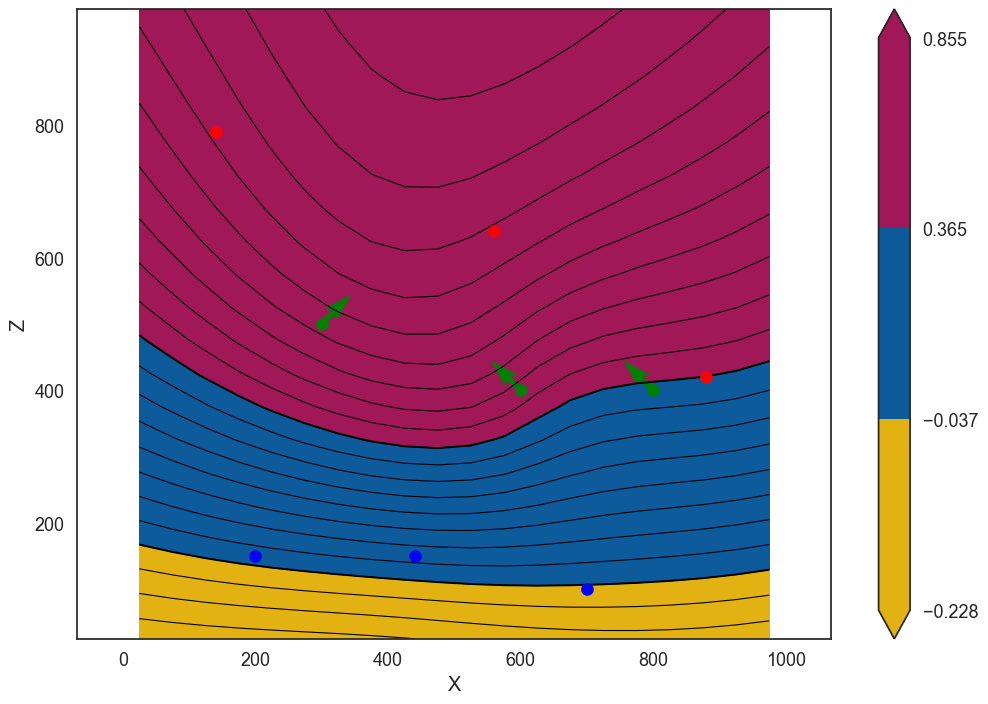

In [35]:
# 1) 取 x–z 平面：固定一個 y 索引（例如中間那層）
y_idx = 0   # 或自訂：y_idx = np.argmin(np.abs((Y0+SCALE*yy) - y0_target))

# 2) 1D 原座標軸（注意：只對座標反正規化）
x1 = X0 + SCALE * np.asarray(x_norm, float)     # 長度 nx
z1 = Z0 + SCALE * np.asarray(z_norm, float)     # 長度 nz

# 3) 取切片並轉置成 (nz, nx) 以配合 (y, x) 的順序
Sxz = np.asarray(scalar_field_drift[:, y_idx, :], float).T   # (nz, nx)

# 4) 層面值（通常是位勢，不縮放；除非你之前把場值也除過 1520）
l1 = float(interp_val_with_drift(i[0], w, i, o))
l2 = float(interp_val_with_drift(i[3], w, i, o))
l1, l2 = sorted([l1, l2])

# 5) 色階
lo, hi = float(np.nanmin(Sxz)), float(np.nanmax(Sxz))
eps = np.finfo(float).eps * max(1.0, abs(hi - lo))
bounds = [b for b in (l1, l2) if np.isfinite(b) and (lo < b < hi)]
levels_fill = np.unique(np.r_[lo - eps, bounds, hi + eps])   # 嚴格遞增
palette = ["#E2B213", "#0D5B9B", "#A01857"]
colors = palette[:max(1, len(levels_fill) - 1)]

# 6) 繪圖（用 1D 座標）
h = plt.contourf(x1, z1, Sxz, levels=levels_fill, colors=colors, extend='both')
plt.colorbar(h, extend='both')

# 等距等高線
if np.isfinite(l1) and np.isfinite(l2) and (l2 > l1):
    m_between = 8
    d = (l2 - l1) / max(1, m_between)
    kmin = int(np.floor((lo - l1) / d))
    kmax = int(np.ceil( (hi - l1) / d))
    levels_lines = l1 + d * np.arange(kmin, kmax + 1)
else:
    levels_lines = np.linspace(lo, hi, 20)
levels_lines = levels_lines[(levels_lines > lo - eps) & (levels_lines < hi + eps)]
for b in (l1, l2):
    if lo < b < hi:
        levels_lines = np.unique(np.r_[levels_lines, b])

plt.contour(x1, z1, Sxz, levels=levels_lines, colors='k', linewidths=0.8, linestyles='solid')
plt.contour(x1, z1, Sxz, levels=[b for b in (l1, l2) if lo < b < hi],
            colors='k', linewidths=1.4, linestyles='solid')

# 7) 投影資料點與向量到 x–z（座標反正規化，向量乘回 SCALE）
ix = X0 + SCALE * i[:, 0]; iy = Y0 + SCALE * i[:, 1]; iz = Z0 + SCALE * i[:, 2]
ox = X0 + SCALE * o[:, 0]; oy = Y0 + SCALE * o[:, 1]; oz = Z0 + SCALE * o[:, 2]
plt.plot(ix[0], iz[0], 'bo'); plt.plot(ix[1], iz[1], 'bo'); plt.plot(ix[2], iz[2], 'bo')
plt.plot(ix[3], iz[3], 'ro'); plt.plot(ix[4], iz[4], 'ro'); plt.plot(ix[5], iz[5], 'ro')
plt.plot(ox[0], oz[0], 'go'); plt.plot(ox[1], oz[1], 'go'); plt.plot(ox[2], oz[2], 'go')

plt.quiver(ox[0], oz[0], SCALE*gx0, SCALE*gz0, color='g')
plt.quiver(ox[1], oz[1], SCALE*gx1, SCALE*gz1, color='g')
plt.quiver(ox[2], oz[2], SCALE*gx2, SCALE*gz2, color='g')

plt.xlabel("X")
plt.ylabel("Z")
plt.axis('equal'); plt.tight_layout(); plt.show()


In [36]:
l1 = float(interp_val_with_drift(i[0], w, i, o))
l2 = float(interp_val_with_drift(i[3], w, i, o))
l1, l2 = sorted([l1, l2])

In [37]:
labels = np.where(scalar_field_drift<=l1, 3, np.where(scalar_field_drift<=l2, 2, 1))

labels_PL = np.where(scalar_field_drift_PL<=l1, 3, np.where(scalar_field_drift_PL<=l2, 2, 1))

In [38]:
labels_PL = scalar_field_drift_PL.copy()

In [39]:
idx = np.flatnonzero(labels.ravel() - geo_data.solutions.raw_arrays.lith_block)
print(f'number of errors: {idx.size}\nfall at point: {idx}')
if idx.size == 0:
    print('all pass')
idx_PL = np.flatnonzero(labels_PL.ravel() - geo_data.solutions.raw_arrays.lith_block)
print(f'number of PL errors: {idx_PL.size}\nfall at point: {idx_PL}')

idx_PL.size / res**3 * 100

number of errors: 0
fall at point: []
all pass
number of PL errors: 33
fall at point: [  64   72  270  423  891 1290 1364 1586 2222 2503 2675 3626 4026 4650
 4887 5155 5247 5915 6529 6611 6758 6882 6909 6963 7208 7228 7242 7289
 7351 7539 7669 7703 7731]


0.41250000000000003

In [40]:
raise Exception("執行已在此手動停止，後續 Cell 將不會執行。")

Exception: 執行已在此手動停止，後續 Cell 將不會執行。

# GemPy整體運算時間

In [ ]:
sample_sizes = [20, 40, 60, 80, 100]
REPEAT = 3
n_list, t_list = [], []
for idx, n in enumerate(sample_sizes):
    acc = 0.0
    for r in range(REPEAT):
        geo_data.grid.regular_grid.resolution = np.array([n, n, n])
        t1 = time.perf_counter()
        gp.compute_model(geo_data)
        t2 = time.perf_counter()    
        acc += (t2 - t1)
    n_list.append(n)
    t_list.append(acc / REPEAT)
numpy_list = t_list

Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
Chunking done: 7 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 7 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 7 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 17 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 17 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 17 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 33 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 33 chunks
Setting Backend To: AvailableBackends.numpy
Chunking done: 33 chunks


In [ ]:
'''
import sys
def switch_gempy_backend(backend_name="PYTORCH"):
    """
    強制移除 gempy 及其所有子模組的快取，並設定新的後端。
    backend_name: "PYTORCH" 或 "NUMPY" (或其他 gempy 支援的後端)
    """
    
    # 1. 找出所有已經載入的 gempy 相關模組
    # GemPy 可能會依賴 gempy_engine 或其他名稱，主要清除 'gempy' 開頭的即可
    modules_to_remove = [m for m in sys.modules.keys() if m.startswith('gempy')]
    
    # 2. 從 sys.modules 中刪除它們
    for module_name in modules_to_remove:
        del sys.modules[module_name]
    
    print(f"已清除 {len(modules_to_remove)} 個 GemPy 相關模組快取。")

    # 3. 設定環境變數
    os.environ["DEFAULT_BACKEND"] = backend_name
    print(f"環境變數 DEFAULT_BACKEND 已設定為: {backend_name}")

    # 4. 重新 import
    global gp
    import gempy as gp
    print(f"GemPy 已重新載入 (Backend: {backend_name})")
switch_gempy_backend("PYTORCH")
np.random.seed(5555)
geo_data: gp.data.GeoModel = gp.create_geomodel(
    project_name='kriging',
    extent=[0, 1000, 0, 1000, 0, 1000],
    resolution=[20,20,20],
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations="orientations.csv",
        path_to_surface_points="points.csv",
    )
)

sample_sizes = [20, 40, 60, 80, 100]
REPEAT = 3
n_list, t_list = [], []
for idx, n in enumerate(sample_sizes):
    acc = 0.0
    for r in range(REPEAT):
        geo_data.grid.regular_grid.resolution = np.array([n, n, n])
        t1 = time.perf_counter()
        gp.compute_model(geo_data)
        t2 = time.perf_counter()    
        acc += (t2 - t1)
    n_list.append(n)
    t_list.append(acc / REPEAT)
'''

'\nimport sys\ndef switch_gempy_backend(backend_name="PYTORCH"):\n    """\n    強制移除 gempy 及其所有子模組的快取，並設定新的後端。\n    backend_name: "PYTORCH" 或 "NUMPY" (或其他 gempy 支援的後端)\n    """\n\n    # 1. 找出所有已經載入的 gempy 相關模組\n    # GemPy 可能會依賴 gempy_engine 或其他名稱，主要清除 \'gempy\' 開頭的即可\n    modules_to_remove = [m for m in sys.modules.keys() if m.startswith(\'gempy\')]\n\n    # 2. 從 sys.modules 中刪除它們\n    for module_name in modules_to_remove:\n        del sys.modules[module_name]\n\n    print(f"已清除 {len(modules_to_remove)} 個 GemPy 相關模組快取。")\n\n    # 3. 設定環境變數\n    os.environ["DEFAULT_BACKEND"] = backend_name\n    print(f"環境變數 DEFAULT_BACKEND 已設定為: {backend_name}")\n\n    # 4. 重新 import\n    global gp\n    import gempy as gp\n    print(f"GemPy 已重新載入 (Backend: {backend_name})")\nswitch_gempy_backend("PYTORCH")\nnp.random.seed(5555)\ngeo_data: gp.data.GeoModel = gp.create_geomodel(\n    project_name=\'kriging\',\n    extent=[0, 1000, 0, 1000, 0, 1000],\n    resolution=[20,20,20],\n    importer_helper=gp.data

已存圖檔: GemPy_time.png
已存 CSV: GemPy_time.csv


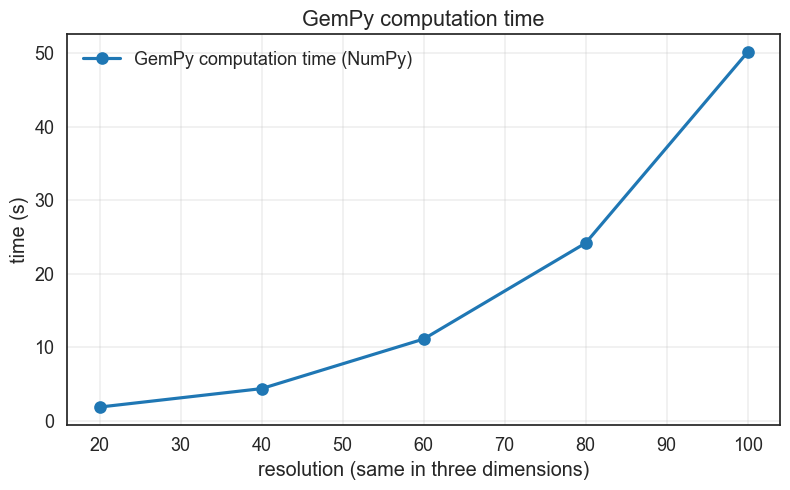

In [ ]:
import csv

LOGX = False
DO_SAVE = True
PNG_PATH = "GemPy_time.png"
CSV_PATH = "GemPy_time.csv"
if DO_SAVE:
    plt.figure(figsize=(8, 5))
    plt.plot(n_list, numpy_list, marker="o", linestyle="-", label="GemPy computation time (NumPy)")
    #plt.plot(n_list, t_list, marker="o", linestyle="-", label="GemPy computation time (PyTorch)")
    if LOGX:
        plt.xscale("log")
    plt.xlabel("resolution (same in three dimensions)")
    plt.ylabel("time (s)")
    plt.title("GemPy computation time")
    plt.grid(True, which="both", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(PNG_PATH, dpi=150)
    with open(CSV_PATH, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["n_samples", "GemPy compute time"])
        for n, t1 in zip(n_list, t_list):
            writer.writerow([n, f"{t1:.9f}"])
    print(f"已存圖檔: {PNG_PATH}")
    print(f"已存 CSV: {CSV_PATH}")

# 模型渲染

In [ ]:
import gempy_viewer as gpv
geo_data: gp.data.GeoModel = gp.create_geomodel(
    project_name='kriging',
    extent=[0, 1000, 0, 1000, 0, 1000],
    resolution=[20,20,20],
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations="orientations.csv",
        path_to_surface_points="points.csv",
    )
)
gp.compute_model(geo_data)

Setting Backend To: AvailableBackends.numpy


Solutions(4 Octree Levels, 2 DualContouringMeshes)

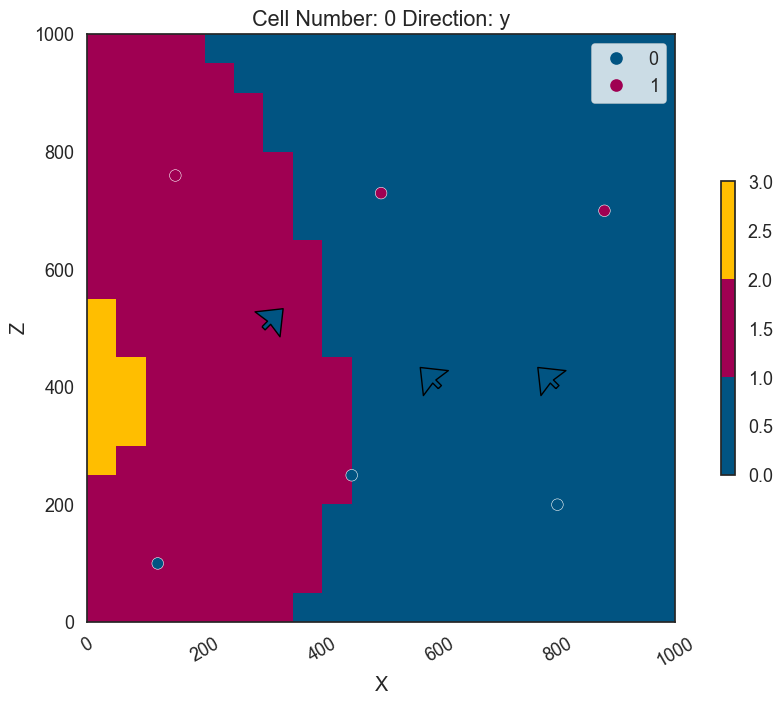

In [ ]:
plot = gpv.plot_2d(geo_data, show_lith=True, show_boundaries=False, direction= 'y', cell_number=0).fig

In [ ]:
gpv.plot_3d(geo_data, show_surfaces=False, image=False, show_data=False)

# 替換為labels後渲染

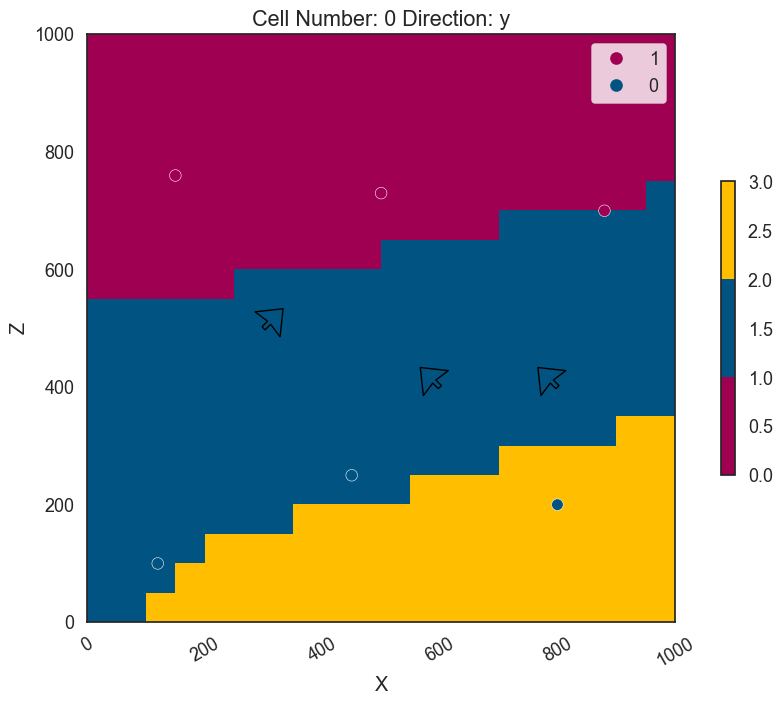

In [ ]:
geo_data.solutions.raw_arrays.lith_block = labels_PL.ravel()
plot = gpv.plot_2d(geo_data, show_lith=True, show_boundaries=False, direction= 'y', cell_number=0).fig

In [ ]:
gpv.plot_3d(geo_data, show_surfaces=False, image=False, show_data=False)

# 自製渲染程式

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

def render_y_slice(labels, x_range, y_range, z_range, nx, ny, nz, y_sel=None, y_index=None, colors=None, show=True):
    """
    labels: 3D 陣列，shape=(Nz,Ny,Nx)，值為 {1,2,3}
    colors: 3 色 hex 或 RGB，可選，預設 ["#E2B213","#0D5B9B","#A01857"]
            對應 1→colors[0], 2→colors[1], 3→colors[2]
    其餘參數同前
    """
    labels = np.asarray(labels)
    if labels.shape != (nz, ny, nx):
        raise ValueError(f"labels.shape 應為 (Nz, Ny, Nx)=({nz},{ny},{nx})，但實際為 {labels.shape}")
    
    if colors is None:
        colors = ["#E2B213", "#0D5B9B", "#A01857"]
    if len(colors) != 3:
        raise ValueError("colors 必須包含 3 個顏色。")
    
    x0, x1 = x_range
    y0, y1 = y_range
    z0, z1 = z_range

    dx = (x1 - x0) / nx
    dy = (y1 - y0) / ny
    dz = (z1 - z0) / nz

    x_centers = x0 + (np.arange(nx) + 0.5) * dx
    y_centers = y0 + (np.arange(ny) + 0.5) * dy
    z_centers = z0 + (np.arange(nz) + 0.5) * dz

    if y_sel is not None:
        y_index = int(np.argmin(np.abs(y_centers - y_sel)))
    elif y_index is None:
        y_index = ny // 2
    if not (0 <= y_index < ny):
        raise ValueError(f"y_index 超出範圍：0..{ny-1}, 得到 {y_index}")
    
    # 垂直於 y 的切片：取得 (z,x) 平面
    slice2d = labels[:, y_index, :]  # (Nz, Nx)

    # 建立離散 colormap 與對應的 BoundaryNorm，讓 1/2/3 精準落到三種顏色
    cmap = ListedColormap(colors)
    norm = BoundaryNorm([0.5, 1.5, 2.5, 3.5], cmap.N)
    
    if show:
        plt.figure()
        im = plt.imshow(
            slice2d,
            origin="lower",
            extent=[x0, x1, z0, z1],
            cmap=cmap,
            norm=norm,
            interpolation="nearest"
        )
        cbar = plt.colorbar(im)
        cbar.set_ticks([1, 2, 3])
        cbar.set_label("Label")
        plt.plot(ix[0], iz[0], 'bo'); plt.plot(ix[1], iz[1], 'bo'); plt.plot(ix[2], iz[2], 'bo')
        plt.plot(ix[3], iz[3], 'ro'); plt.plot(ix[4], iz[4], 'ro'); plt.plot(ix[5], iz[5], 'ro')
        plt.plot(ox[0], oz[0], 'go'); plt.plot(ox[1], oz[1], 'go'); plt.plot(ox[2], oz[2], 'go')

        plt.quiver(ox[0], oz[0], SCALE*gx0, SCALE*gz0, color='g')
        plt.quiver(ox[1], oz[1], SCALE*gx1, SCALE*gz1, color='g')
        plt.quiver(ox[2], oz[2], SCALE*gx2, SCALE*gz2, color='g')
        plt.xlabel("X")
        plt.ylabel("Z")
        plt.title(f"Y-slice at index {y_index}, y={y_centers[y_index]:.4g}")
        plt.show()
    
    return slice2d, (x_centers, y_centers, z_centers), y_index

# ---- Demo：建立一個簡單的標籤體，隨機 1/2/3（您可換成自己的 labels）----
nx, ny, nz = 20, 20, 20

# 定義渲染範圍（以實際單位或任意座標系）
x_range = (0, 1000)
y_range = (0, 1000)
z_range = (0, 1000)

# 以 y 的座標值取切片（例如 y=0.75）
_, _, fig_slice  = render_y_slice(labels.T, x_range, y_range, z_range, nx, ny, nz, y_sel=0, colors=[ "#A01857", "#0D5B9B", "#E2B213"],show=True)


In [ ]:
import pyvista as pv
# --- 判斷是否在 notebook，選用合適的互動後端 ---
def _in_notebook():
    try:
        from IPython import get_ipython
        return get_ipython() is not None and "ipykernel" in sys.modules
    except Exception:
        return False

IN_NOTEBOOK = _in_notebook()
if IN_NOTEBOOK:
    try:
        pv.set_jupyter_backend('pythreejs')  # 互動 3D 後端
    except Exception:
        pv.set_jupyter_backend('client')     # 備援

# ====== 你的資料 ======
# xx, yy, zz 為「正規化後」1D 座標；Z3 為 3D 標量場 (nx, ny, nz)
Z3 = np.asarray(labels, float)
l1, l2 = 2, 1

# ── (可選) 只有當你曾經把「標量場的值本身」也除以 1520 時，才要放大回來 ──
# Z3 = SCALE * Z3
# l1, l2 = SCALE * l1, SCALE * l2

# ====== 反正規化座標軸 ======
xx_o = X0 + SCALE * np.asarray(xx, float)
yy_o = Y0 + SCALE * np.asarray(yy, float)
zz_o = Z0 + SCALE * np.asarray(zz, float)

# ====== PyVista 影像網格（UniformGrid）======
nx, ny, nz = Z3.shape
dx = float(xx_o[1] - xx_o[0]) if len(xx_o) > 1 else 1.0
dy = float(yy_o[1] - yy_o[0]) if len(yy_o) > 1 else 1.0
dz = float(zz_o[1] - zz_o[0]) if len(zz_o) > 1 else 1.0

grid = pv.ImageData()
grid.dimensions = (nx, ny, nz)  # 點數；要與 Z3.shape 對上
grid.spacing    = (dx, dy, dz)
grid.origin     = (float(xx_o.min()), float(yy_o.min()), float(zz_o.min()))
grid['s']       = Z3.ravel(order='F')  # 以點為標量（Fortran 展平，對應 nx-ny-nz 順序）

# ====== 三色體渲染（<l1 黃、l1~l2 藍、≥l2 紅）======
#lo, hi = float(np.nanmin(Z3)), float(np.nanmax(Z3))
lo, hi = 0, 3
eps = 1e-12

L = np.array([1,2,3])
grid['level'] = np.digitize(grid['s'], (L[1:]+L[:-1])/2) + 1  # 1/2/3 分類
high = grid.extract_points(grid['level']==1, adjacent_cells=True)
mid  = grid.extract_points(grid['level']==2, adjacent_cells=True)
low  = grid.extract_points(grid['level']==3, adjacent_cells=True)


p = pv.Plotter(notebook=IN_NOTEBOOK)

def add_if_not_empty(mesh, **kwargs):
    if hasattr(mesh, "n_cells") and mesh.n_cells > 0:
        p.add_mesh(mesh, **kwargs)

add_if_not_empty(low,  color="#E2B213", opacity=0.25, show_edges=False)  # 黃
add_if_not_empty(mid,  color="#0D5B9B", opacity=0.25, show_edges=False)  # 藍
add_if_not_empty(high, color="#A01857", opacity=0.25, show_edges=False)  # 紅

# ====== 邊界等值面（l1 / l2）======
#iso_levels = [v for v in (l1, l2) if lo < v < hi]
#for val, color in zip(iso_levels, ["#0D5B9B", "#A01857"]):
#    surf = grid.contour(isosurfaces=[val], scalars='s')
#    if surf.n_cells > 0:
#        p.add_mesh(surf, color=color, opacity=0.6, show_edges=True)

# ====== 外觀與互動 ======
p.add_axes(); p.show_grid()
p.camera_position = 'iso'
p.enable_anti_aliasing()
p.show()
